In [133]:
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
from flax import struct

from jaxav.dynamics import DroneState, step
from jaxav.pytree import tree_stack, to_numpy
from jaxav.visualization import render
from jaxav.control import RateController, PositionController
from jaxav.math import euler_to_quat, quat_rotate

from tqdm import tqdm

import yaml
drone = "jaxav/asset/hummingbird.yaml"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [224]:
class Env():
    def __init__(self) -> None:
        state_0 = DroneState.load(drone)
        self.num_drones = 1
        self.state_0 = tree_stack([state_0 for _ in range(self.num_drones)])

    def reset(self, params=None):
        env_state = self.state_0.replace(
            pos=self.state_0.pos.at[..., 2].set(2.),
            # rot=self.state_0.rot.at[:].set(euler_to_quat(jnp.array([0., 0.25*jnp.pi, 0.])))
        )
        return env_state
    
    def step(self, env_state, action, key=None):
        env_state = jax.vmap(step)(env_state, action)
        return env_state

with open(drone, "r") as f:
    params = yaml.safe_load(f)

env = Env()
state = env.reset()

rate_ctrl = RateController()
rate_ctrl_params = tree_stack([rate_ctrl.init(params) for _ in range(1)])
rate_ctrl_ref = (
    jnp.zeros((1,4))
    .at[:, 2].set(jnp.pi)
    .at[:, 3].set(state.mass * 9.81)
)
pos_ctrl = PositionController()
pos_ctrl_params = tree_stack([pos_ctrl.init(params) for _ in range(1)])
pos_ctrl_ref = (
    jnp.zeros((1,7))
    .at[:, :3].set(jnp.array([1., 0., 2.5]))
    .at[:, 6].set(jnp.pi/3)
)

up = quat_rotate(jnp.array([0., 0., 1.]), state.rot[0])
states = [state]
# action = jnp.ones_like(state.thro) * -1.
# action = jnp.broadcast_to(jnp.array([0., 1., 0., 1.]), state.thro.shape)
env_step = jax.jit(env.step)
# env_step = env.step
# state = state.replace(angvel=state.angvel.at[..., 2].set(jnp.pi))
for i in tqdm(range(256)):
    action = jax.vmap(pos_ctrl)(state, pos_ctrl_ref, pos_ctrl_params)
    # action = jax.vmap(rate_ctrl)(state, rate_ctrl_ref, rate_ctrl_params)
    state = env_step(state, action)
    if i % 2 == 0:
        states.append(state)
    
action, state.pos, state.rot

100%|██████████| 256/256 [00:10<00:00, 24.70it/s]


(Array([[-0.41601402, -0.41691554, -0.41632336, -0.41651165]], dtype=float32),
 Array([[1.0061020e+00, 2.1965436e-03, 2.5038507e+00]], dtype=float32),
 Array([[8.6738473e-01, 6.4765872e-04, 7.6390128e-04, 4.9763533e-01]],      dtype=float32))

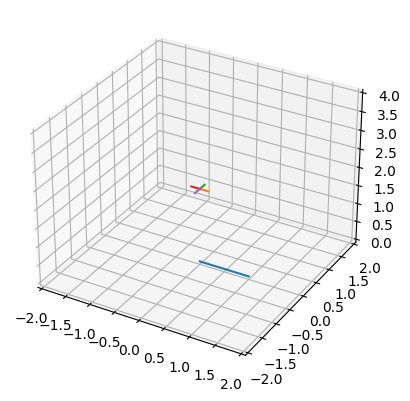

In [225]:
anim = render(states)
with open("render.html", "w") as f:
    f.write(anim.to_jshtml())

In [195]:
quat_rotate(jnp.array([0., 0., 1.]), state.rot[0])

Array([0.6313715 , 0.59600323, 0.4961355 ], dtype=float32)

In [185]:
up

Array([0., 0., 1.], dtype=float32)